# Plot Paloma data

## Imports and setup

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

import wandb

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    ),
}
mpl.rcParams.update(rc_fonts)


def format_ticks(x, pos):
    return str(int(x // 1000))


wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: yw580 (pico-lm). Use `wandb login --relogin` to force relogin


True

In [2]:
TICK_LABEL_SIZE = 14
AXIS_LABEL_SIZE = 16

## Get data from runs

In [7]:
api = wandb.Api()

RUN_SCALE = "tiny"

if RUN_SCALE == "tiny":
    baseline_run = api.run("pico-lm/pico-decoder/lne20rc1")  # pico decoder tiny
    relora_run = api.run("pico-lm/pico-relora/6vhmv4aj")  # pico relora tiny
else:
    baseline_run = api.run("pico-lm/pico-decoder/kzcalg17")
    relora_run = api.run("pico-lm/pico-relora/5urfvs2j")


baseline_df = pd.DataFrame(baseline_run.scan_history())
relora_df = pd.DataFrame(relora_run.scan_history())

In [8]:
def get_data_from_df(df: pd.DataFrame, metric: str, every: int = 1000, max_step: int = 20_000):
    # Pre-select only needed columns for better memory usage
    cols = ["trainer/global_step", metric]
    df_subset = df[cols]

    # Mask conditions
    steps = df_subset["trainer/global_step"]
    mask = (steps <= max_step) & (steps % every == 0) & df_subset[metric].notna()

    # Apply mask once and return as tuple of arrays
    filtered = df_subset[mask]
    return filtered["trainer/global_step"].to_numpy(), filtered[metric].to_numpy()

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_75480/781165496.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


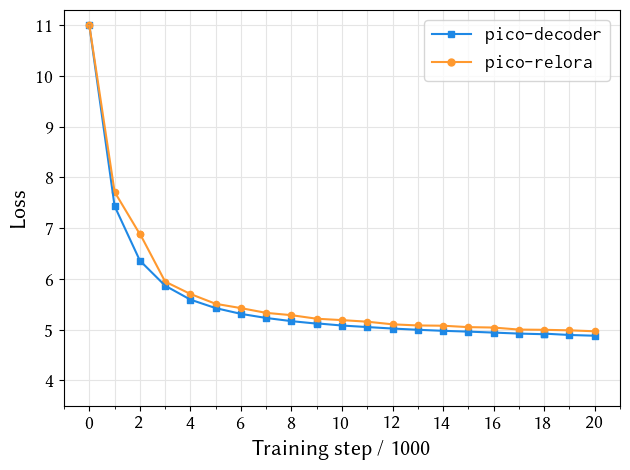

In [9]:
baseline_data_loss = get_data_from_df(baseline_df, "train/loss")
relora_data_loss = get_data_from_df(relora_df, "train/loss")

fig, ax = plt.subplots()

colors = ["#1E88E5", "#FF992F"]

ax.scatter(*baseline_data_loss, color=colors[0], marker="s", s=20)
ax.plot(*baseline_data_loss, color=colors[0])

ax.scatter(*relora_data_loss, color=colors[1], marker="o", s=20)
ax.plot(*relora_data_loss, color=colors[1])

ax.set_xlabel("Training step / 1000", fontdict={"size": AXIS_LABEL_SIZE})
ax.set_ylabel("Loss", fontdict={"size": AXIS_LABEL_SIZE})

ax.set_ylim(3.5, 11.3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1000))
ax.set_axisbelow(True)
ax.grid(which="both", axis="both", color="#E5E5E5")

ax.tick_params(axis="both", labelsize=TICK_LABEL_SIZE)

legend_elements = [
    Line2D(
        [0], [0], color=colors[0], marker="s", linestyle="-", label=r"\texttt{pico-decoder}", markersize=5
    ),
    Line2D(
        [0], [0], color=colors[1], marker="o", linestyle="-", label=r"\texttt{pico-relora}", markersize=5
    ),
]

ax.legend(handles=legend_elements, fontsize=TICK_LABEL_SIZE)

fig.tight_layout()
fig.savefig(f"../graphs/{RUN_SCALE}_loss.pdf")
fig.show()

/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_75480/3957717922.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


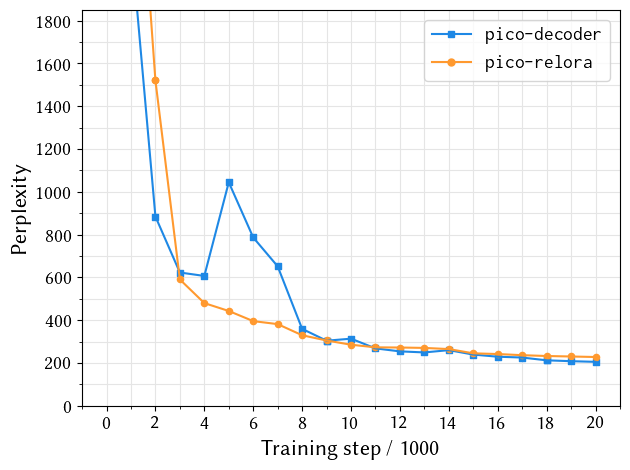

In [10]:
baseline_data_paloma = get_data_from_df(baseline_df, "eval/paloma")
relora_data_paloma = get_data_from_df(relora_df, "eval/paloma")

fig, ax = plt.subplots()

colors = ["#1E88E5", "#FF992F"]

ax.scatter(*baseline_data_paloma, color=colors[0], marker="s", s=20)
ax.plot(*baseline_data_paloma, color=colors[0])

ax.scatter(*relora_data_paloma, color=colors[1], marker="o", s=20)
ax.plot(*relora_data_paloma, color=colors[1])

ax.set_xlabel("Training step / 1000", fontdict={"size": AXIS_LABEL_SIZE})
ax.set_ylabel("Perplexity", fontdict={"size": AXIS_LABEL_SIZE})

ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_ticks))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1000))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(100))
ax.set_axisbelow(True)
ax.grid(which="both", axis="both", color="#E5E5E5")

ax.tick_params(axis="both", labelsize=TICK_LABEL_SIZE)


y_ticks = np.arange(0, 1801, 200)
ax.set_yticks(y_ticks, minor=False)
ax.set_ylim(0, 1850)

legend_elements = [
    Line2D(
        [0], [0], color=colors[0], marker="s", linestyle="-", label=r"\texttt{pico-decoder}", markersize=5
    ),
    Line2D(
        [0], [0], color=colors[1], marker="o", linestyle="-", label=r"\texttt{pico-relora}", markersize=5
    ),
]

ax.legend(handles=legend_elements, fontsize=TICK_LABEL_SIZE)

fig.tight_layout()
fig.savefig(f"../graphs/{RUN_SCALE}_ppl.pdf")
fig.show()